<a href="https://colab.research.google.com/github/Rukayat-spec/Variational_Autoencoder/blob/main/VAE_Tutorial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Variational Autoencoders (VAEs): A Deep Dive into Latent Representations and Data Generation

# Importing necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from PIL import Image
from tqdm import tqdm_notebook as tqdm

# Set batch size and device
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Creating class to handle Image Loading and Transformations

In [ ]:
# Dataset class to handle image loading and transformations
class Load_Dataset(Dataset):
    def __init__(self, img_dir, transform1=None, transform2=None):
        self.img_dir = img_dir
        self.img_names = os.listdir(img_dir)
        self.transform1 = transform1
        self.transform2 = transform2

        self.imgs = []
        for img_name in self.img_names:
            img = Image.open(os.path.join(img_dir, img_name))
            if self.transform1 is not None:
                img = self.transform1(img)
            self.imgs.append(img)

    def __getitem__(self, index):
        img = self.imgs[index]
        if self.transform2 is not None:
            img = self.transform2(img)
        return img

    def __len__(self):
        return len(self.imgs)


# Resizing and Center Croping the Images

In [ ]:
# First preprocessing of data: resize and center crop images
transform1 = transforms.Compose([transforms.Resize(64), transforms.CenterCrop(64)])

# Data augmentation and conversion to tensors
random_transforms = [transforms.RandomRotation(degrees=10)]
transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Creating dataste and dataloader

In [ ]:
# Create dataset and dataloader
train_dataset = Load_Dataset(
    img_dir='/content/drive/MyDrive/Dogs',  # Modify with correct path to your data
    transform1=transform1,
    transform2=transform2
)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Visualizing some images

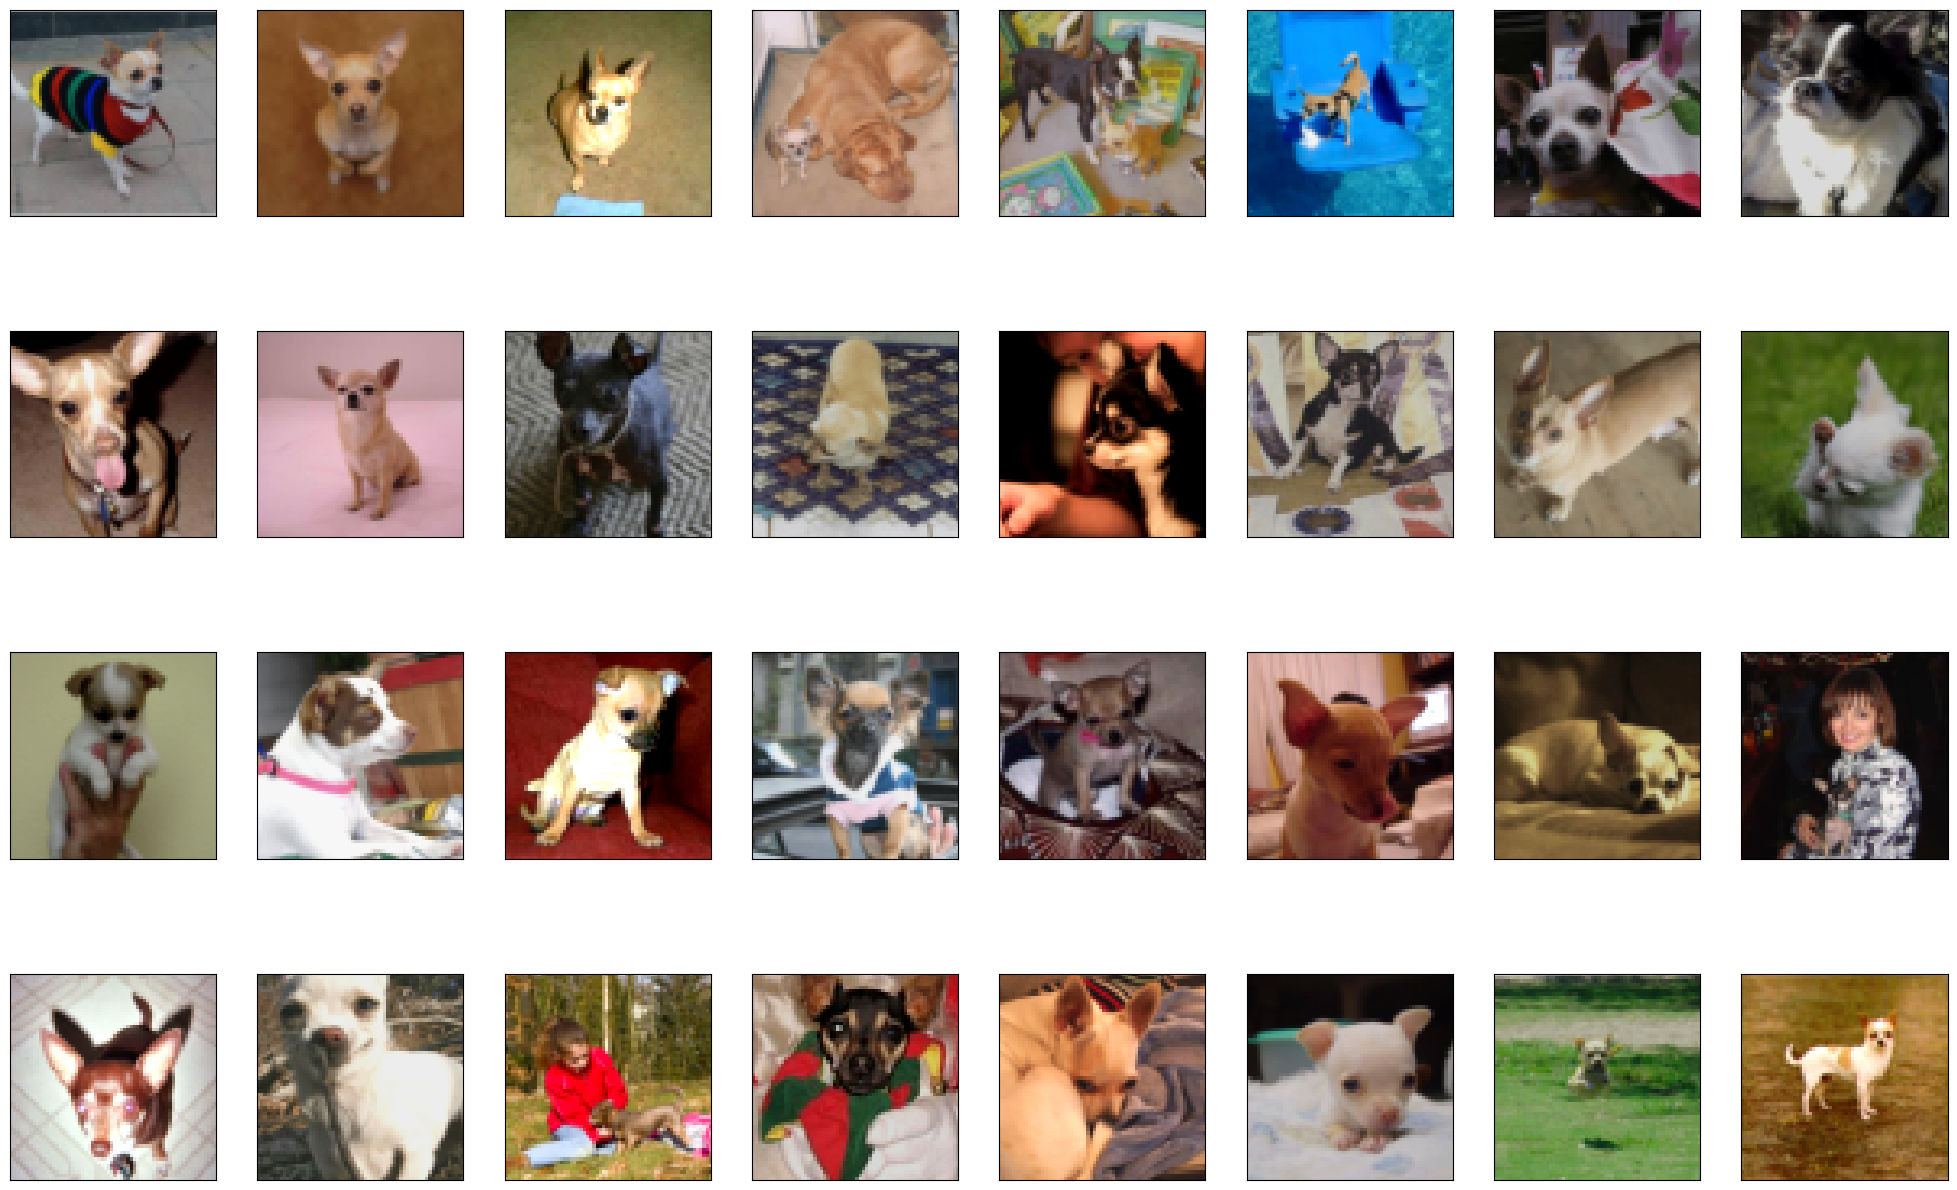

In [ ]:
# Visualize some images
x = next(iter(train_loader))
fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(x):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    img = img.numpy().transpose(1, 2, 0)
    plt.imshow((img+1.)/2.)


# Defining Variational Autoencoder

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import VGG16_Weights

class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x

class SharpVAE(nn.Module):
    def __init__(self, latent_dim=256, no_of_sample=10, batch_size=32, channels=3):
        super(SharpVAE, self).__init__()
        self.no_of_sample = no_of_sample
        self.batch_size = batch_size
        self.channels = channels
        self.latent_dim = latent_dim
        self.current_epoch = 0

        # Enhanced Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(channels, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            ResBlock(64)
        )

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            ResBlock(128)
        )

        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            ResBlock(256)
        )

        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            ResBlock(512)
        )

        self.fc_mu = nn.Conv2d(512, latent_dim, 4, stride=2, padding=1)
        self.fc_var = nn.Conv2d(512, latent_dim, 4, stride=2, padding=1)

        # Enhanced Decoder with skip connections
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            ResBlock(512)
        )

        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(512 * 2, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            ResBlock(256)
        )

        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(256 * 2, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            ResBlock(128)
        )

        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(128 * 2, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            ResBlock(64)
        )

        self.final_conv = nn.Sequential(
            nn.Conv2d(64 * 2, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, channels, 3, padding=1),
            nn.Tanh()
        )

        # VGG for perceptual loss
        vgg = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        self.feature_extractor = nn.Sequential(*list(vgg.features)[:31]).eval()
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def encode(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)

        mu = self.fc_mu(e4)
        logvar = self.fc_var(e4)

        return mu, logvar, (e1, e2, e3, e4)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z, encoder_features):
        e1, e2, e3, e4 = encoder_features

        d1 = self.dec1(z)
        d1 = torch.cat([d1, e4], dim=1)

        d2 = self.dec2(d1)
        d2 = torch.cat([d2, e3], dim=1)

        d3 = self.dec3(d2)
        d3 = torch.cat([d3, e2], dim=1)

        d4 = self.dec4(d3)
        d4 = torch.cat([d4, e1], dim=1)

        return self.final_conv(d4)

    def forward(self, x):
        mu, logvar, encoder_features = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, encoder_features), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        # Enhanced reconstruction loss
        mse_loss = F.mse_loss(recon_x, x)
        l1_loss = F.l1_loss(recon_x, x)

        # Multiple-scale perceptual loss
        recon_features = self.get_features(recon_x)
        target_features = self.get_features(x)
        perceptual_loss = F.mse_loss(recon_features, target_features)

        # Adaptive KL divergence weight
        kld_weight = max(0.2, 0.5 * (1 + torch.sin(torch.tensor(2 * 3.14159 * self.current_epoch / 20))))
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        kld_loss = kld_loss / (self.batch_size * 3 * 64 * 64)

        # Total loss with balanced weights
        total_loss = mse_loss + 0.7 * l1_loss + 0.3 * perceptual_loss + kld_weight * kld_loss
        return total_loss

    def get_features(self, x):
        return self.feature_extractor(x)

# Setting Learning rate, epochs and latent dimension

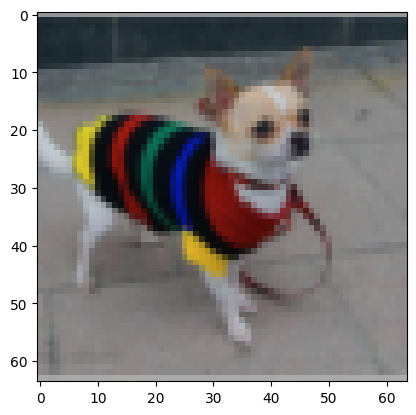

In [ ]:
# Hyperparameters
lr = 0.0005
epochs = 10
latent_dim = 256

# Initialize model and optimizer
model = SharpVAE(latent_dim=latent_dim, batch_size=32).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

# Visualize a sample image
plt.imshow((x[0].numpy().transpose(1, 2, 0) + 1) / 2.)
plt.show()


# Creating Training Loop

Epoch 0, Batch 0, Loss 1.6280


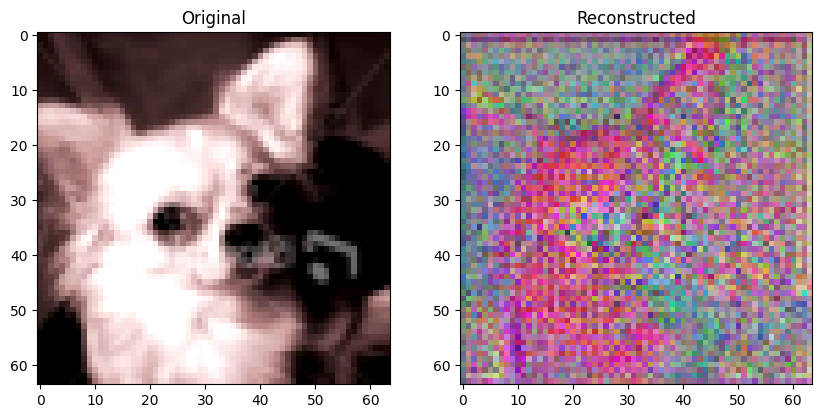

Epoch 0, Average Loss 1.1472
Epoch 1, Batch 0, Loss 0.6904


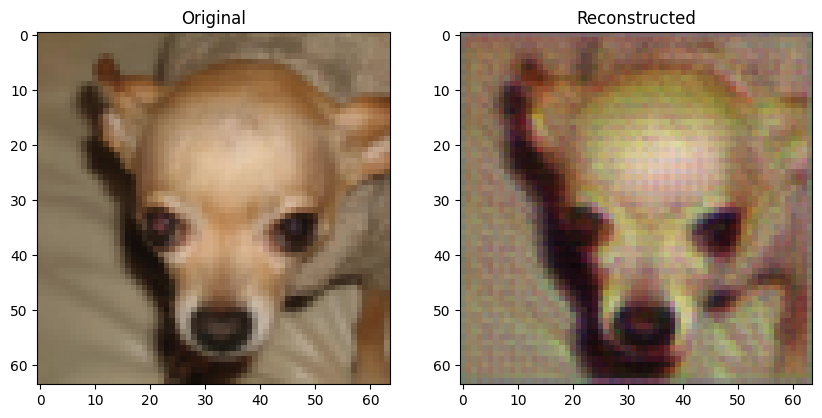

Epoch 1, Average Loss 0.5854
Epoch 2, Batch 0, Loss 0.4729


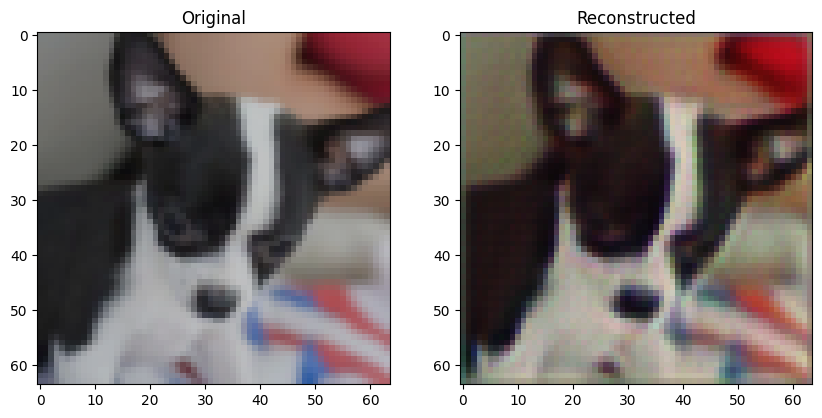

Epoch 2, Average Loss 0.4185
Epoch 3, Batch 0, Loss 0.2918


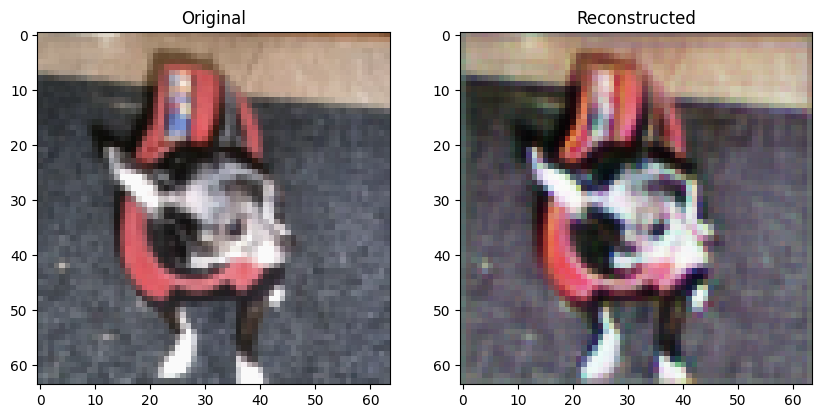

Epoch 3, Average Loss 0.2890
Epoch 4, Batch 0, Loss 0.2222


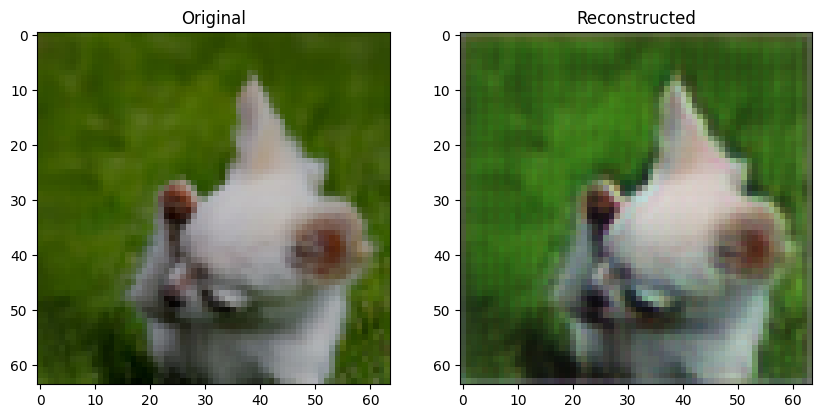

Epoch 4, Average Loss 0.2240
Epoch 5, Batch 0, Loss 0.2220


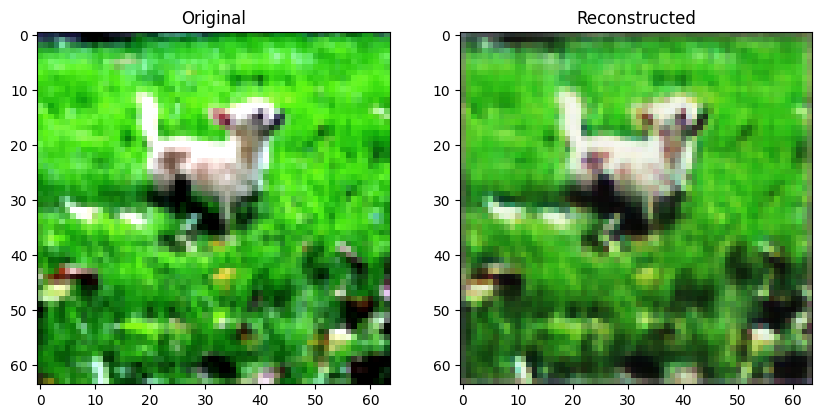

Epoch 5, Average Loss 0.2022
Epoch 6, Batch 0, Loss 0.2023


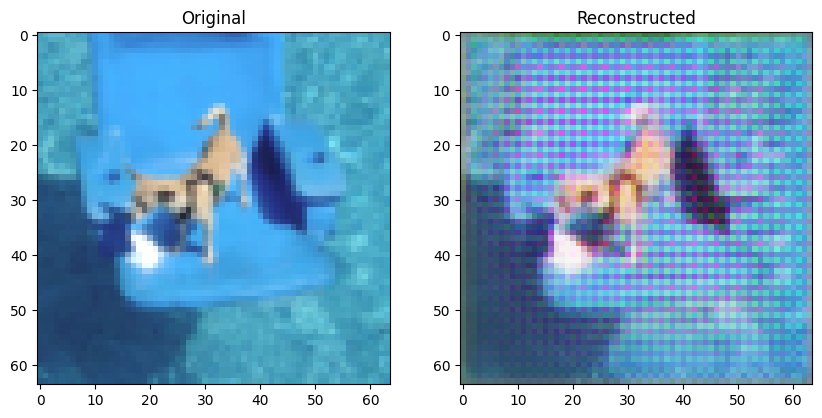

Epoch 6, Average Loss 0.1915
Epoch 7, Batch 0, Loss 0.2002


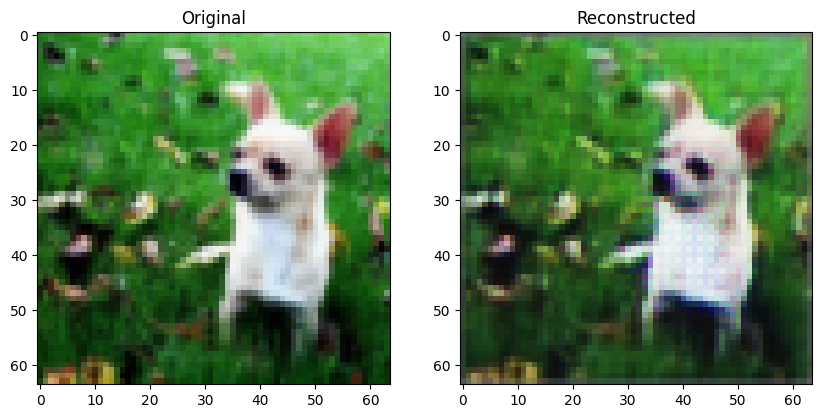

Epoch 7, Average Loss 0.1609
Epoch 8, Batch 0, Loss 0.1485


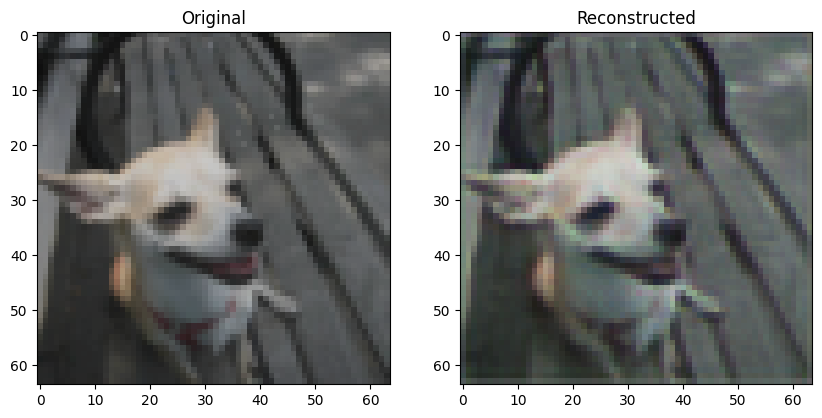

Epoch 8, Average Loss 0.1563
Epoch 9, Batch 0, Loss 0.1515


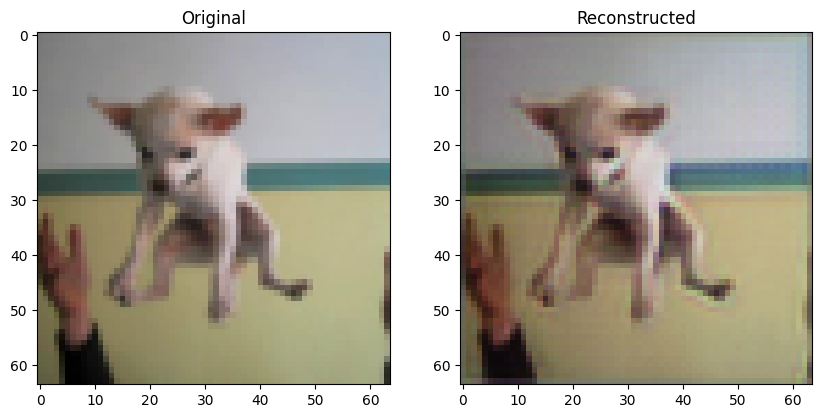

Epoch 9, Average Loss 0.1462


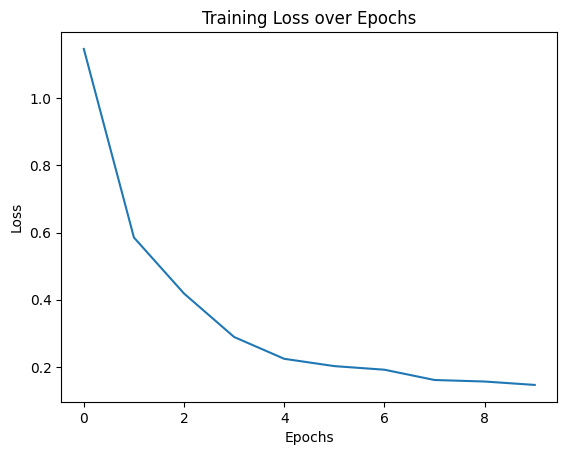

In [ ]:
import matplotlib.pyplot as plt

# List to store the training losses for plotting
train_losses = []

# Training loop
for epoch in range(epochs):
    model.current_epoch = epoch
    epoch_loss = 0.0  # Initialize epoch loss to zero for each epoch

    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = model(data)

        # Compute loss
        loss = model.loss_function(recon_batch, data, mu, logvar)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Optimizer step
        optimizer.step()

        # Accumulate loss for the epoch
        epoch_loss += loss.item()

        # Print loss and show visualization at specific intervals (e.g., every 100 batches)
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}, Loss {loss.item():.4f}')

            # Visualization: Show original and reconstructed images
            with torch.no_grad():
                model.eval()
                plt.figure(figsize=(10, 5))

                # Original Image
                plt.subplot(1, 2, 1)
                original_img = data[0].cpu().numpy().transpose(1, 2, 0)
                plt.imshow((original_img + 1.) / 2.)  # Normalize to [0, 1]
                plt.title('Original')

                # Reconstructed Image
                plt.subplot(1, 2, 2)
                recon_img = recon_batch[0].cpu().detach().numpy().transpose(1, 2, 0)
                plt.imshow((recon_img + 1.) / 2.)  # Normalize to [0, 1]
                plt.title('Reconstructed')

                plt.show()
                model.train()

    # Store the average loss for the epoch
    train_losses.append(epoch_loss / len(train_loader))

    # Step the scheduler
    scheduler.step()

    # Print the average loss for the epoch
    print(f'Epoch {epoch}, Average Loss {epoch_loss / len(train_loader):.4f}')

# Plot the training loss after all epochs
plt.plot(range(epochs), train_losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


# Generating and visualizing reconstructed images

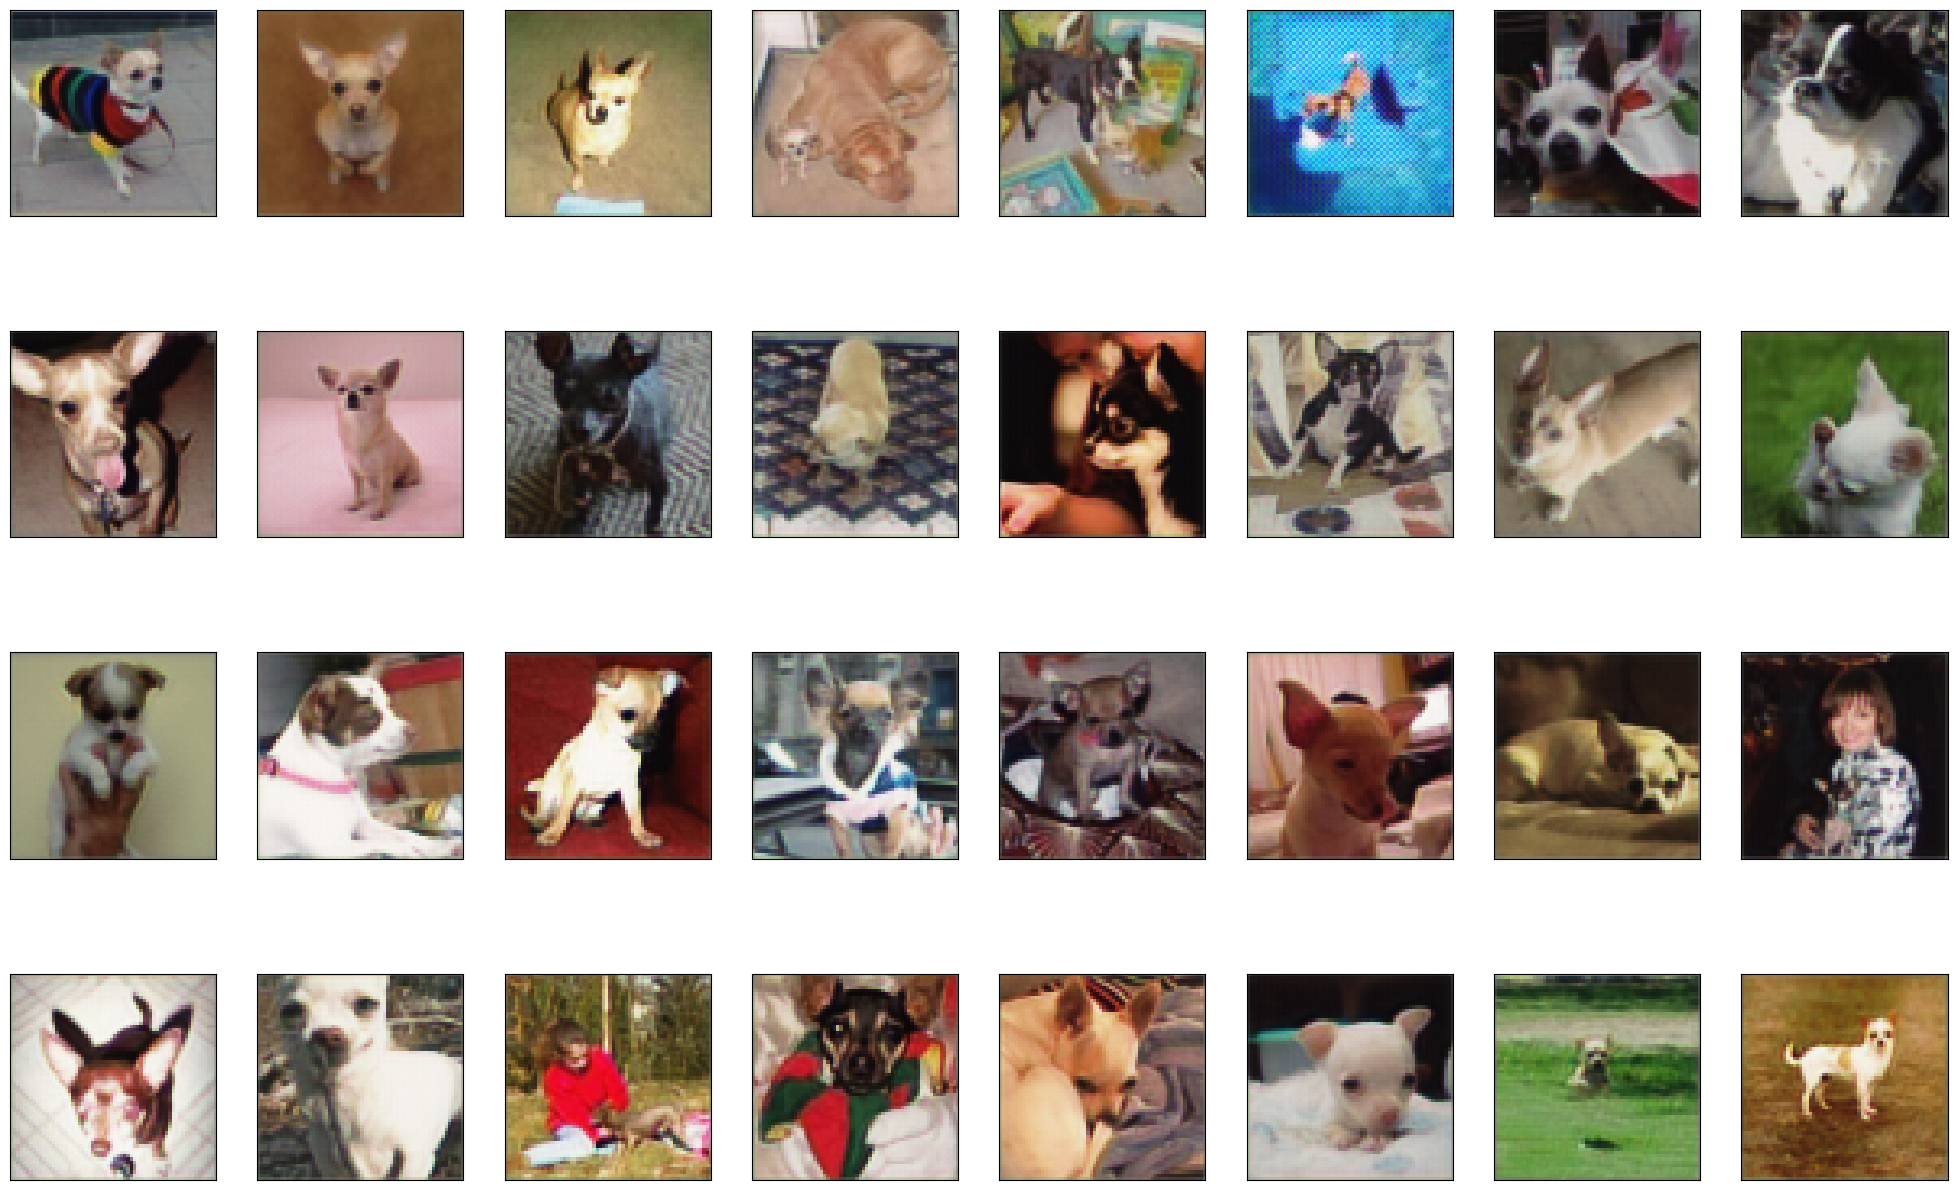

In [ ]:
# Generate and visualize reconstructed images
reconstructed, mu, _ = model(x.to(device))
reconstructed = reconstructed.view(-1, 3, 64, 64).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(reconstructed):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img + 1.) / 2.)


# Evaluation: Reconstructed images and Interpolation

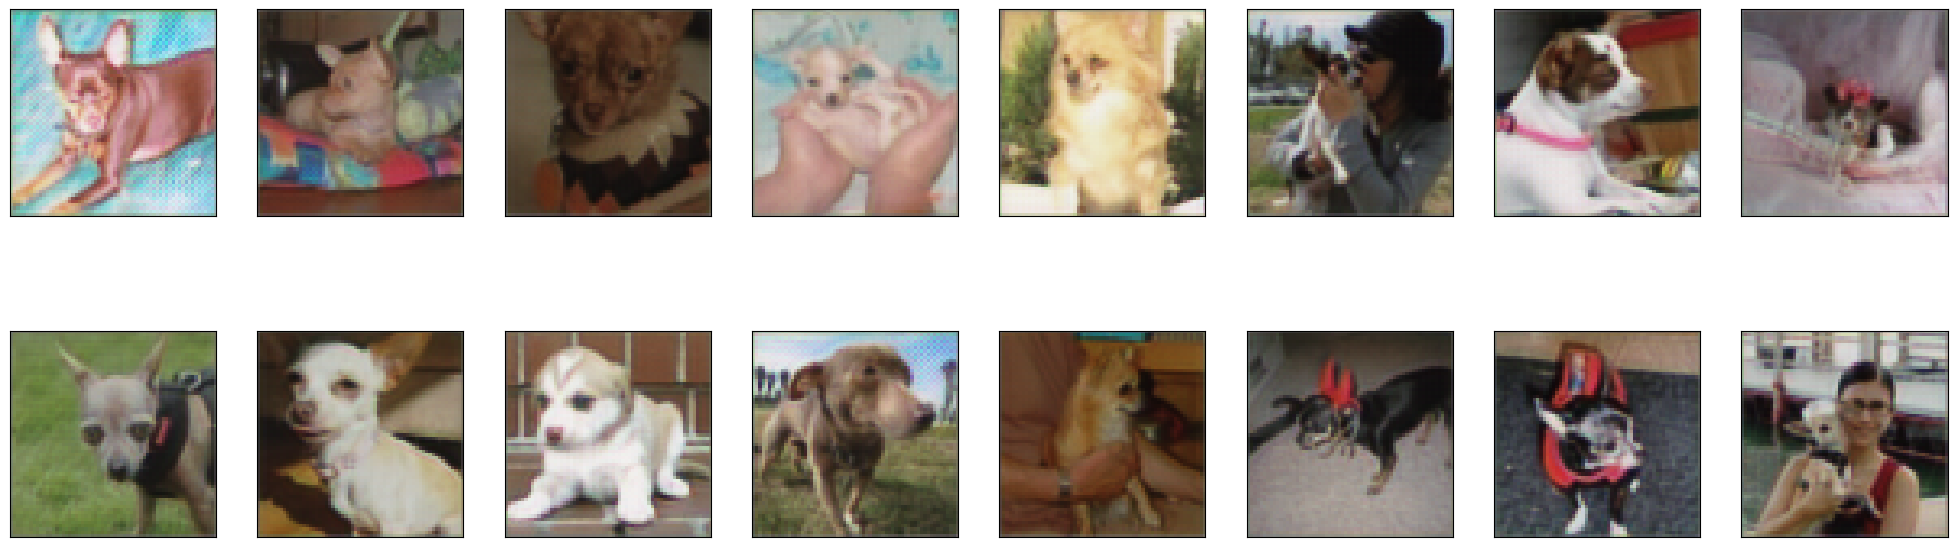

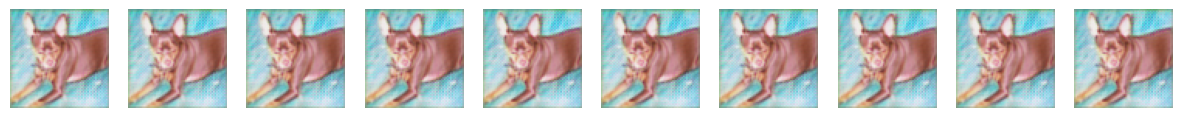

In [ ]:
# Evaluation: Reconstructed images and Interpolation
def evaluate_model():
    # Generating and visualizing reconstructed images
    model.eval()
    with torch.no_grad():
        x_batch = next(iter(train_loader)).to(device)
        reconstructed, _, _ = model(x_batch)
        reconstructed = reconstructed.cpu().numpy().transpose(0, 2, 3, 1)

        fig = plt.figure(figsize=(25, 16))
        for ii, img in enumerate(reconstructed[:16]):
            ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
            plt.imshow((img + 1.) / 2.)

        plt.show()

        # Generate interpolations - This was missing in the original code
        first_dog_idx = 0
        second_dog_idx = 1
        num_interpolation_steps = 10  # You can adjust this

        # Get the latent representations for the two chosen images
        with torch.no_grad():
            _, mu, _ = model(x_batch)
            z1 = mu[first_dog_idx].unsqueeze(0)  # Latent representation of first image
            z2 = mu[second_dog_idx].unsqueeze(0)  # Latent representation of second image

        # Interpolate between the latent representations
        interpolation = []
        for alpha in np.linspace(0, 1, num_interpolation_steps):
            z_interp = (1 - alpha) * z1 + alpha * z2
            # Decode the interpolated latent representation
            interp_img = model.decode(z_interp, model.encode(x_batch[0].unsqueeze(0))[2]).cpu().numpy().transpose(0, 2, 3, 1)
            interpolation.append(interp_img)


        # Visualize interpolation
        fig, axes = plt.subplots(1, num_interpolation_steps, figsize=(15, 5))
        for i, ax in enumerate(axes):
            ax.imshow((interpolation[i][0] + 1.) / 2.)
            ax.axis('off')
        plt.show()

evaluate_model()

# Latent Space Visualization

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


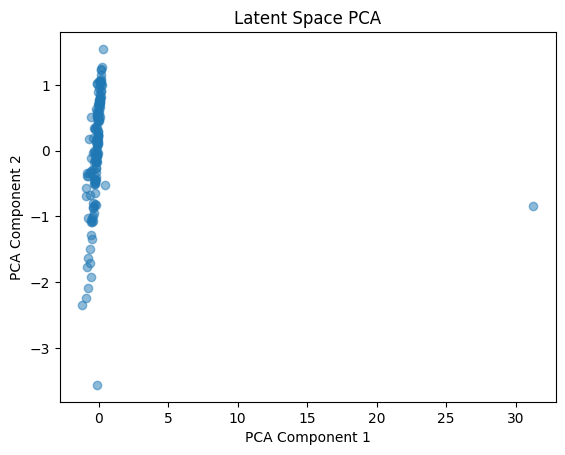

In [ ]:
# 1. Latent Space Visualization
from sklearn.decomposition import PCA

def plot_latent_space():
    model.eval()
    all_latents = []
    all_labels = []

    with torch.no_grad():
        for data in train_loader:
            data = data.to(device)
            _, mu, _ = model(data)
            # Reshape mu before appending
            # Reshape to (batch_size, latent_dim * height * width)
            mu = mu.view(mu.size(0), -1)
            all_latents.append(mu.cpu().numpy())
            # For visualization, you may assign labels (e.g., from filenames or categories)

    all_latents = np.concatenate(all_latents, axis=0)

    # Reduce to 2D using PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(all_latents)

    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
    plt.title('Latent Space PCA')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

plot_latent_space()